# Datasets creation

In [2]:
import os
from itertools import product

import numpy as np
import pandas as pd
from datasets import load_dataset
from functional import seq
from srai.loaders.osm_loaders.filters import HEX2VEC_FILTER
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm
from transformers import CLIPTokenizer

from map_generation.osm_dataset import TextToImageDataset, create_sentence

/home/marcin/Documents/mgr/nw/nw_venv/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/home/marcin/Documents/mgr/nw/srai-tiles/srai/loaders/_base.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://sha

# Prepare data

In [3]:
def _flatten_tags(tags):
    tags_flat = (
        seq(tags.items())
        .starmap(lambda k, v: product([k], v if isinstance(v, list) else [v]))
        .flatten()
        .map(lambda x: "_".join(x))
        .list()
    )
    return tags_flat
columns = _flatten_tags(HEX2VEC_FILTER)
columns[:5]

['aeroway_aerodrome',
 'aeroway_apron',
 'aeroway_gate',
 'aeroway_hangar',
 'aeroway_helipad']

# Saving metadata to image folders
Code creates csv with tags in each city's tiles folder. Metadata.csv is used to generate captions.

Due to changes in srai.SippyMapRegionizer this code does not run with embeddings present in drive. You can skip this step - on drive are folders with created metadata.csv or use freshly created embeddings with previous notebook.

In [4]:
for city in tqdm(os.listdir("../data/tiles")):
    if os.path.exists(f"../data/embeddings/{city}.pkl"):
        df = pd.read_pickle(f"../data/embeddings/{city}.pkl")
        df = df.reindex(columns=columns, fill_value=0)
        df.index = df.index + ".png"
        df.index = df.index.rename("file_name")
        path = f"../data/tiles/{city}/metadata.csv"
        print(f"saving to {path}")
        df.to_csv(path)
    else :
        print(city, "not found")

  0%|          | 0/3 [00:00<?, ?it/s]

saving to ../data/tiles/Milan, Italy/metadata.csv


 33%|███▎      | 1/3 [00:00<00:01,  1.94it/s]

saving to ../data/tiles/Dresden, Germany/metadata.csv


100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

saving to ../data/tiles/Barcelona, Spain/metadata.csv


In [18]:
df = pd.read_pickle(f"../data/embeddings/{city}.pkl")
df = df.reindex(columns=columns, fill_value=0)
df.index = df.index + ".png"
df

,aeroway_aerodrome,aeroway_apron,aeroway_gate,aeroway_hangar,aeroway_helipad,aeroway_heliport,aeroway_navigationaid,aeroway_runway,aeroway_taxiway,aeroway_terminal,...,waterway_lock_gate,waterway_pressurised,waterway_river,waterway_riverbank,waterway_stream,waterway_tidal_channel,waterway_turning_point,waterway_water_point,waterway_waterfall,waterway_weir
file_name,,,,,,,,,,,,,,,,,,,,,
33141_24468_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33142_24465_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
33142_24466_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33142_24467_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33142_24468_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33163_24492_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33163_24493_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33163_24494_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Get prepared data and push to huggingface hub

In [4]:
ds = TextToImageDataset("../data/tiles/Wroclaw, PL")


None


Resolving data files:   0%|          | 0/4139 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/marcin/.cache/huggingface/datasets/imagefolder/tiles-01a7c0d800e744bb/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/marcin/.cache/huggingface/datasets/imagefolder/tiles-01a7c0d800e744bb/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-40f9524c6a32b001.arrow


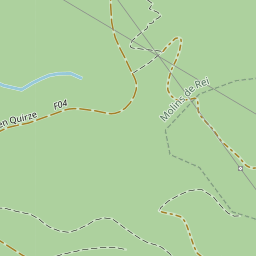

'OSM of area containing: 1 landuse forest  , 1 leisure nature reserve  .'

In [5]:
display(ds[0][0])
ds[0][1]

In [ ]:
hds = ds.to_huggingface_dataset()
hds.push_to_hub("mprzymus/text2tile_small")

In [3]:
large_ds = TextToImageDataset("../data/tiles/").to_huggingface_dataset()
large_ds.push_to_hub("mprzymus/text2tile_large")

Resolving data files: 100%|██████████| 135611/135611 [00:01<00:00, 117838.97it/s]


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1026.76it/s]


Dataset imagefolder downloaded and prepared to /home/marcin/.cache/huggingface/datasets/imagefolder/tiles-bb44cbe6b3b6f93d/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]
Pushing split train to the Hub.
Pushing dataset shards to the dataset hub: 100%|██████████| 7/7 [09:13<00:00, 79.10s/it]


# Check download works

In [4]:
ds = load_dataset("mprzymus/text2tile_small")
ds

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2144 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /home/marcin/.cache/huggingface/datasets/mprzymus___parquet/mprzymus--text2tile_small-c83afa8267529a0a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'caption'],
        num_rows: 2144
    })
})